**Importing Dataset**

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.69G/2.70G [00:21<00:00, 207MB/s]
100% 2.70G/2.70G [00:21<00:00, 135MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/new-plant-diseases-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

**Importing necessary libraries**

In [16]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

In [5]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train',
    labels='inferred',
    batch_size=32,
    image_size=(256,256)
)

val_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',
    labels='inferred',
    batch_size=32,
    image_size=(256,256)
)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [6]:
class_names = sorted(os.listdir('/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'))
class_indices = dict(zip(range(len(class_names)), class_names))

In [7]:
json.dump(class_indices, open('class_indices.json', 'w'))

**Normalizing the pixel values**

In [8]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

**Model** **defining**

In [9]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(38, activation='softmax')
])

**Model compiling**

In [10]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                        

**Model training**

In [12]:
history = model.fit_generator(train_ds,
          validation_data=val_ds,
          epochs = 10)

Epoch 1/10


<ipython-input-12-c44b83ca379a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_ds,


2197/2197 [==============================] - 403s 178ms/step - loss: 1.7001 - accuracy: 0.5281 - val_loss: 0.7494 - val_accuracy: 0.7997
Epoch 2/10
2197/2197 [==============================] - 390s 177ms/step - loss: 0.8445 - accuracy: 0.7557 - val_loss: 0.3960 - val_accuracy: 0.8964
Epoch 3/10
2197/2197 [==============================] - 392s 178ms/step - loss: 0.5719 - accuracy: 0.8326 - val_loss: 0.2583 - val_accuracy: 0.9239
Epoch 4/10
2197/2197 [==============================] - 393s 179ms/step - loss: 0.4304 - accuracy: 0.8735 - val_loss: 0.2163 - val_accuracy: 0.9376
Epoch 5/10
2197/2197 [==============================] - 390s 177ms/step - loss: 0.3354 - accuracy: 0.9014 - val_loss: 0.1765 - val_accuracy: 0.9463
Epoch 6/10
2197/2197 [==============================] - 392s 178ms/step - loss: 0.2759 - accuracy: 0.9185 - val_loss: 0.1409 - val_accuracy: 0.9552
Epoch 7/10
2197/2197 [==============================] - 390s 177ms/step - loss: 0.2331 - accuracy: 0.9311 - val_loss: 0.125

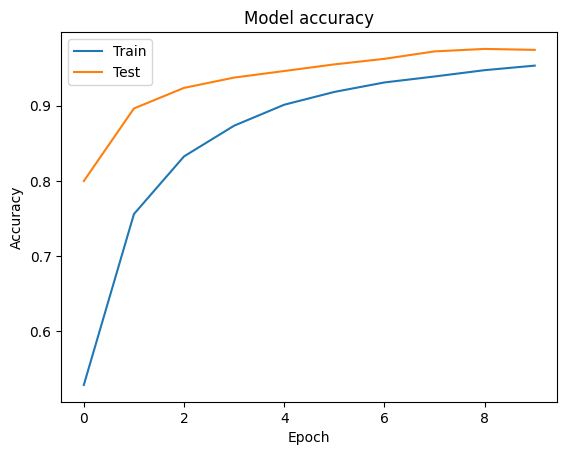

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

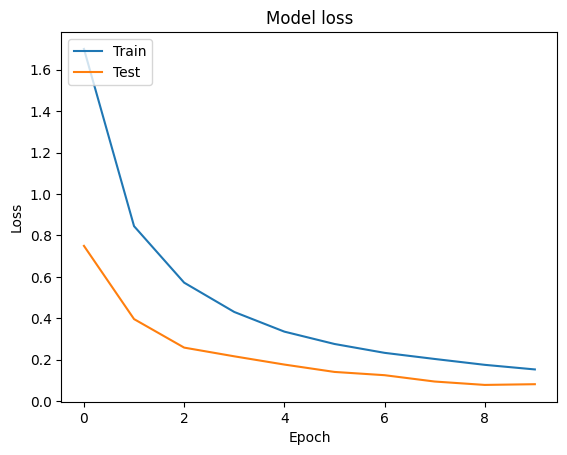

In [14]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Prediction Model**

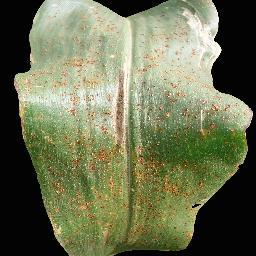

In [34]:
image_path = "/content/test/test/CornCommonRust2.JPG"
image = Image.open(image_path)
image

In [35]:
def preprocess_image(image):
    image_array = np.array(image) / 255.0
    input_image = np.expand_dims(image_array, axis=0)
    return input_image

In [36]:
input_img=preprocess_image(image)

In [37]:
def diseases_pred(input_image):
  predictions = model.predict(input_image)
  predicted_class_index = np.argmax(predictions)
  predicted_class_name = class_indices[predicted_class_index]
  return predicted_class_name

In [38]:
pred=diseases_pred(input_img)

1/1 [==============================] - 0s 20ms/step


In [39]:
print("Predicted class:", pred)


Predicted class: Corn_(maize)___Common_rust_


**Saving the Model**

In [33]:
model.save("detection_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
